In [47]:
# Imports and Setup
import pandas as pd
import numpy as np
from pathlib import Path
import sys
import logging
import json
import torch
from tqdm import tqdm
from matplotlib import pyplot as plt
import seaborn as sns
import importlib

# Add project root to path
sys.path.append(str(Path.cwd().parent))

# Import and reload modules to get fresh changes
from src.models.predictor import TrollPredictor
from src.data_tools.czech_data_tools import load_czech_media_data
import src.models.predictor
importlib.reload(src.models.predictor )

# Configure matplotlib and seaborn
plt.style.use('default')
sns.set_theme()

In [48]:
# Reinitialize the predictor after reload
predictor = TrollPredictor(
    model_path='../checkpoints/best_model.pt',
    comments_per_user=5,
    max_length=64
)

In [6]:
MODEL_DIR = Path('../checkpoints')
DATA_DIR = Path('../data')

# Initialize predictor with best model
predictor = TrollPredictor(
    model_path=str(MODEL_DIR / 'best_model.pt'),
    comments_per_user=5,
    max_length=64
)

In [7]:
czech_comments = load_czech_media_data(str(DATA_DIR / 'MediaSource'))
print(f"Loaded {len(czech_comments)} comments from {czech_comments['author'].nunique()} unique authors")

Loading files: 100%|██████████████████████████████████████████████████████| 124/124 [00:04<00:00, 25.36it/s]


Loaded 846098 comments from 66607 unique authors


In [8]:
# Display data info
print("\nDataset columns:", czech_comments.columns.tolist())
print("\nSample of comments:")
print(czech_comments[['text', 'author', 'sentiment']].head())


Dataset columns: ['text', 'author', 'timestamp', 'article_title', 'url', 'article_id', 'sentiment']

Sample of comments:
                                                text        author   sentiment
0                        Umí i něco jiného než lhát?   Jiří Mraček    Negative
1  Nezávislost na Rusku je lež jako věž z Ruska b...  Fiala Václav    Negative
2  Vsak jak jinak. Pořád si stěžovali, že se musí...   Jana Krejci     Neutral
3  Jedna reforma školství stíhá druhou, hlavně ab...   Jiří Flusek     Neutral
4  Frantisek LuftNaštěstí to vychází z logiky int...   Honza Novak  Ambivalent


In [9]:
# Save processed data
PROCESSED_DIR = DATA_DIR / 'processed'
PROCESSED_DIR.mkdir(exist_ok=True)
czech_comments.to_parquet(PROCESSED_DIR / 'czech_media_comments.parquet')

In [10]:
# Make Predictions
results = []
for idx, group in tqdm(czech_comments.groupby('author')):
    texts = group['text'].tolist()
    
    # Get prediction
    pred = predictor.predict_batch(texts)
    
    # Store results
    results.append({
        'author': idx,
        'n_comments': len(texts),
        'prediction': pred['prediction'],
        'confidence': pred['confidence'],
        'troll_probability': pred['probabilities'][1]
    })

# Convert to DataFrame
results_df = pd.DataFrame(results)

100%|████████████████████████████████████████████████████████████████| 66607/66607 [05:58<00:00, 185.76it/s]


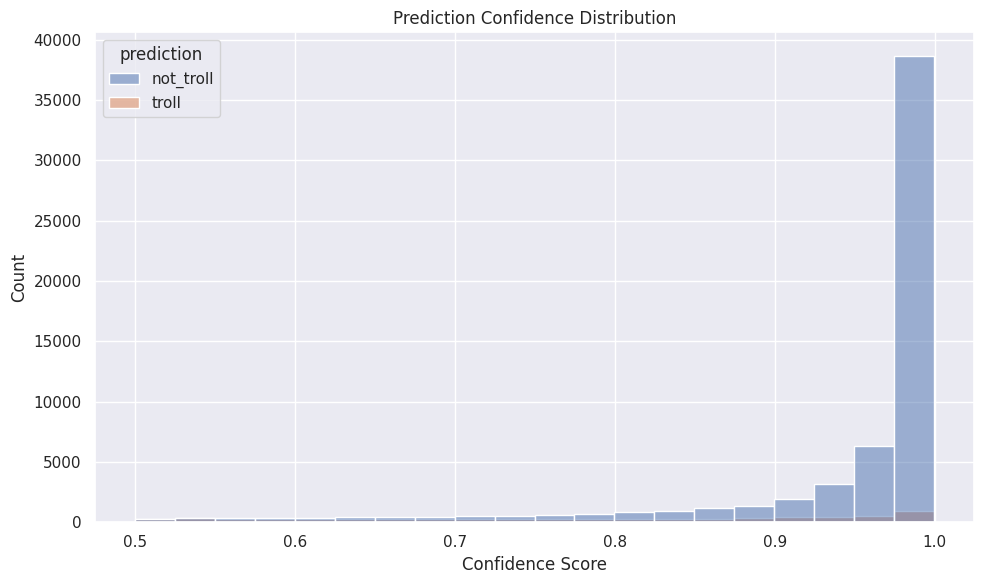


=== High Confidence Troll Predictions ===

Found 2351 high confidence troll predictions

--- High Confidence Prediction 1 ---
Author: Viktor Šrámek
Confidence: 0.997
Troll Probability: 0.997

Sample comments:
--------------------------------------------------------------------------------
Trump kolaboroval s Ruskem !!!
----------------------------------------

--- High Confidence Prediction 2 ---
Author: Petr Riman
Confidence: 0.997
Troll Probability: 0.997

Sample comments:
--------------------------------------------------------------------------------
Trump velmi precizně!
----------------------------------------

--- High Confidence Prediction 3 ---
Author: Zbenda Z
Confidence: 0.997
Troll Probability: 0.997

Sample comments:
--------------------------------------------------------------------------------
Ein Musk fur alle der kleine Trump hilfer :)
----------------------------------------

=== Uncertain Predictions (Medium Confidence) ===

Found 1047 medium confidence predictions

In [11]:
# Cell: Analyze predictions by confidence levels
# Create visualization
plt.figure(figsize=(10, 6))
sns.histplot(
    data=results_df, 
    x='confidence', 
    hue='prediction', 
    bins=20
)
plt.title('Prediction Confidence Distribution')
plt.xlabel('Confidence Score')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Print analysis of high confidence predictions
print("\n=== High Confidence Troll Predictions ===")
high_conf_trolls = results_df[
    (results_df['prediction'] == 'troll') & 
    (results_df['confidence'] >= 0.9)
].sort_values('confidence', ascending=False)

if len(high_conf_trolls) > 0:
    print(f"\nFound {len(high_conf_trolls)} high confidence troll predictions")
    for i, (_, row) in enumerate(high_conf_trolls.head(3).iterrows(), 1):
        print(f"\n--- High Confidence Prediction {i} ---")
        print(f"Author: {row['author']}")
        print(f"Confidence: {row['confidence']:.3f}")
        print(f"Troll Probability: {row['troll_probability']:.3f}")
        print("\nSample comments:")
        print("-" * 80)
        # Get comments for this author
        author_comments = czech_comments[czech_comments['author'] == row['author']]['text'].head(2)
        for comment in author_comments:
            print(comment[:200] + "..." if len(comment) > 200 else comment)
            print("-" * 40)
else:
    print("No high confidence troll predictions found")

# Print analysis of uncertain predictions
print("\n=== Uncertain Predictions (Medium Confidence) ===")
medium_conf = results_df[
    (results_df['confidence'] >= 0.6) & 
    (results_df['confidence'] < 0.7) &
    (results_df['prediction'] == 'troll')
].sort_values('confidence')

if len(medium_conf) > 0:
    print(f"\nFound {len(medium_conf)} medium confidence predictions")
    for i, (_, row) in enumerate(medium_conf.head(3).iterrows(), 1):
        print(f"\n--- Medium Confidence Prediction {i} ---")
        print(f"Author: {row['author']}")
        print(f"Prediction: {row['prediction']}")
        print(f"Confidence: {row['confidence']:.3f}")
        print(f"Troll Probability: {row['troll_probability']:.3f}")
        print("\nSample comments:")
        print("-" * 80)
        # Get comments for this author
        author_comments = czech_comments[czech_comments['author'] == row['author']]['text'].head(2)
        for comment in author_comments:
            print(comment[:200] + "..." if len(comment) > 200 else comment)
            print("-" * 40)
else:
    print("No medium confidence predictions found")

# Save detailed results
output_dir = Path('../output')
output_dir.mkdir(exist_ok=True)
high_conf_trolls.to_csv(output_dir / 'high_confidence_predictions.csv', index=False)
medium_conf.to_csv(output_dir / 'medium_confidence_predictions.csv', index=False)

In [12]:
results_df.head()

,author,n_comments,prediction,confidence,troll_probability
0,*,1,not_troll,0.707831,0.292169
1,007 Bradley,1,not_troll,0.970445,0.029555
2,1. Jiří Kratochvíl,5,not_troll,0.990438,0.009562
3,11345,1,not_troll,0.993912,0.006088
4,1zus,1,not_troll,0.996915,0.003085


In [14]:
from src.data_tools.czech_data_tools import export_troll_comments_by_confidence

export_troll_comments_by_confidence(
    predictions_df=results_df,
    comments_df=czech_comments,
    min_confidence=0.9,
    output_file="../output/troll_comments_by_confidence.json"
)

Processing comments: 100%|██████████████████████████████████████████████| 2351/2351 [02:16<00:00, 17.28it/s]



Exported 16228 comments from 2351 authors
Output saved to: ../output/troll_comments_by_confidence.json


In [49]:
def explain_author(
    author_name: str, 
    predictor_instance: TrollPredictor, 
    comments_df: pd.DataFrame, 
    display_plots: bool = True,
    use_correlation: bool = True
):
    """Interactive function to explain why an author was classified as a troll using multiple methods"""
    
    # Get author's comments
    author_comments = comments_df[comments_df['author'] == author_name]['text'].tolist()
    
    if not author_comments:
        print(f'No comments found for author: {author_name}')
        return
        
    # Get prediction first
    pred = predictor_instance.predict_batch(author_comments)
    
    if pred['prediction'] != 'troll':
        print(f'Author {author_name} is not classified as a troll (confidence: {pred["confidence"]:.3f})')
        return
    
    print(f"\nAnalyzing author: {author_name}")
    print(f"Prediction confidence: {pred['confidence']:.3f}")
    print(f"Troll probability: {pred['probabilities'][1]:.3f}")
    
    # Generate occlusion sensitivity explanation
    print("\n=== Occlusion Sensitivity Analysis ===")
    explanation = predictor_instance.explain_prediction(author_comments)
    
    # Print occlusion sensitivity results
    for i, exp in enumerate(explanation['explanations'], 1):
        print(f"\nComment {i}:")
        print(f"Text: {exp['tweet_text']}")
        print("\nMost influential tokens (Occlusion Sensitivity):")
        
        # Create a table with token contributions
        contrib_data = []
        for contrib in exp['token_contributions']:
            direction = "Supporting" if contrib['contribution'] == 'positive' else "Opposing"
            contrib_data.append([
                contrib['token'],
                f"{contrib['importance']:.4f}",
                direction
            ])
        
        contrib_df = pd.DataFrame(contrib_data, columns=['Token', 'Importance', 'Effect'])
        print(contrib_df.to_string(index=False))
        
        if display_plots:
            img = plt.imread(exp['plot_filename'])
            plt.figure(figsize=(12, 4))
            plt.imshow(img)
            plt.axis('off')
            plt.title(f'Occlusion Sensitivity Analysis - Comment {i}')
            plt.show()
        
        print("-" * 80)
    
    # Generate correlation analysis if requested
    if use_correlation:
        print("\n=== Token Correlation Analysis ===")
        correlation_explanation = predictor_instance.explain_with_correlation(author_comments)
        
        for i, exp in enumerate(correlation_explanation['explanations'], 1):
            print(f"\nComment {i}:")
            print(f"Text: {exp['tweet_text']}")
            print("\nMost influential tokens (Correlation Analysis):")
            
            # Create a table with token contributions
            contrib_data = []
            for contrib in exp['token_contributions']:
                direction = "Supporting" if contrib['contribution'] == 'positive' else "Opposing"
                contrib_data.append([
                    contrib['token'],
                    f"{contrib['importance']:.4f}",
                    direction
                ])
            
            contrib_df = pd.DataFrame(contrib_data, columns=['Token', 'Importance', 'Effect'])
            print(contrib_df.to_string(index=False))
            
            if display_plots:
                img = plt.imread(exp['plot_filename'])
                plt.figure(figsize=(12, 4))
                plt.imshow(img)
                plt.axis('off')
                plt.title(f'Token Correlation Analysis - Comment {i}')
                plt.show()
            
            print("-" * 80)


Analyzing author: Stefan Hinduliak
Prediction confidence: 0.901
Troll probability: 0.901

=== Occlusion Sensitivity Analysis ===

Generating explanations using occlusion sensitivity...

Processing tweet 1/5
Occlusion analysis for Tweet 1:
Text: jan kaislera job zabili mu deti
Plot saved to: importance_tweet_1.png
Top contributing tokens:
  - '##sler': 0.1409 (supporting the prediction)
  - 'za': 0.1177 (supporting the prediction)
  - '##bili': 0.0643 (supporting the prediction)
  - '##a': -0.0340 (opposing the prediction)
  - 'mu': -0.0289 (opposing the prediction)
  - 'job': -0.0262 (opposing the prediction)
  - 'det': -0.0259 (opposing the prediction)
  - '##i': -0.0217 (opposing the prediction)

Processing tweet 2/5
Occlusion analysis for Tweet 2:
Text: tomáš vybíralmas pravdu babis je laciny a podbizivy
Plot saved to: importance_tweet_2.png
Top contributing tokens:
  - '##áš': -0.0250 (opposing the prediction)
  - 'tom': -0.0222 (opposing the prediction)
  - '##mas': -0.0192 (oppo

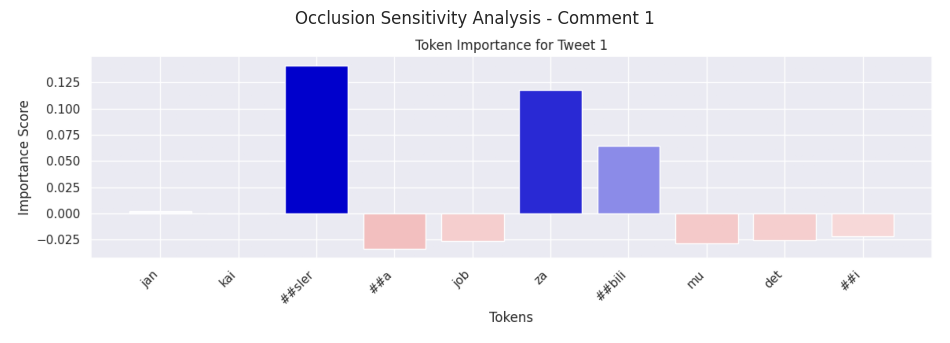

--------------------------------------------------------------------------------

Comment 2:
Text: tomáš vybíralmas pravdu babis je laciny a podbizivy

Most influential tokens (Occlusion Sensitivity):
Token Importance     Effect
 ##áš    -0.0250   Opposing
  tom    -0.0222   Opposing
##mas    -0.0192   Opposing
   je    -0.0187   Opposing
   ba     0.0149 Supporting
 ##bí    -0.0147   Opposing
  ##y    -0.0130   Opposing
 ##bi    -0.0103   Opposing
  ##y    -0.0102   Opposing


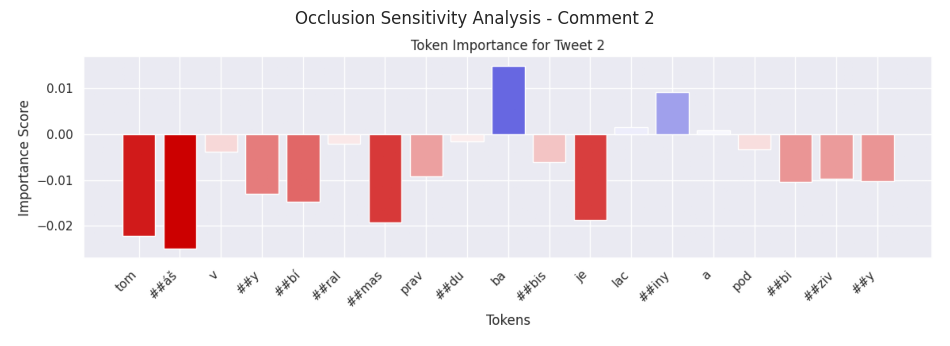

--------------------------------------------------------------------------------

Comment 3:
Text: jaroslav jiráčektak aspon ty nerad

Most influential tokens (Occlusion Sensitivity):
Token Importance     Effect
##ros     0.1008 Supporting
##lav     0.0675 Supporting
   ja     0.0426 Supporting
 nera    -0.0282   Opposing
 ##on     0.0221 Supporting
   ty     0.0137 Supporting


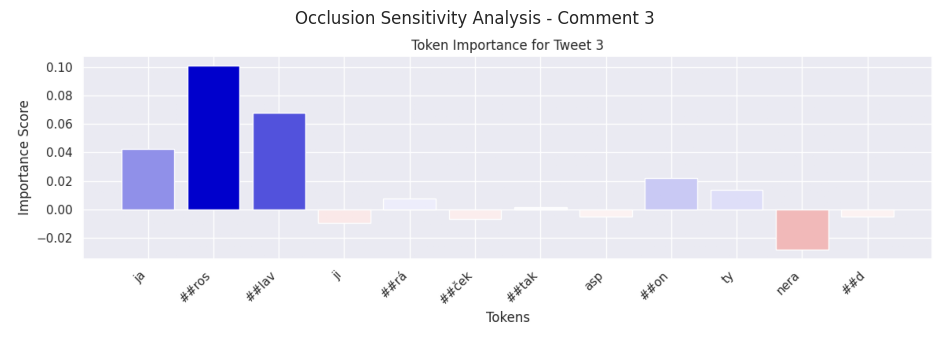

--------------------------------------------------------------------------------

Comment 4:
Text: slávek halaa nebo kdo je pravda pane pomtsky pilate

Most influential tokens (Occlusion Sensitivity):
 Token Importance     Effect
   ##k     0.0171 Supporting
 ##áve    -0.0125   Opposing
    pi     0.0115 Supporting
##late     0.0114 Supporting
 ##sky     0.0113 Supporting
  nebo     0.0104 Supporting


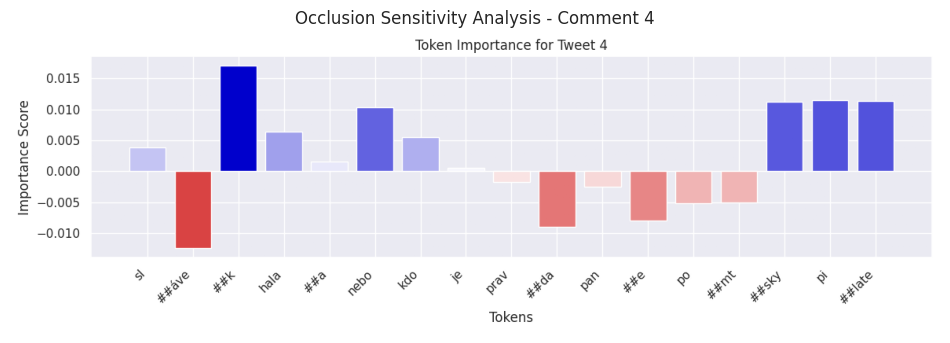

--------------------------------------------------------------------------------

Comment 5:
Text: miloš valentakarol satoria to vidi podobne za cenu strat zrno prinesie urodu

Most influential tokens (Occlusion Sensitivity):
  Token Importance     Effect
 ##oria     0.0302 Supporting
  ##odu     0.0247 Supporting
  ##nta     0.0164 Supporting
   ##oš    -0.0145   Opposing
    mil     0.0138 Supporting
   vale    -0.0138   Opposing
      z    -0.0118   Opposing
   cenu     0.0113 Supporting
podobne    -0.0113   Opposing


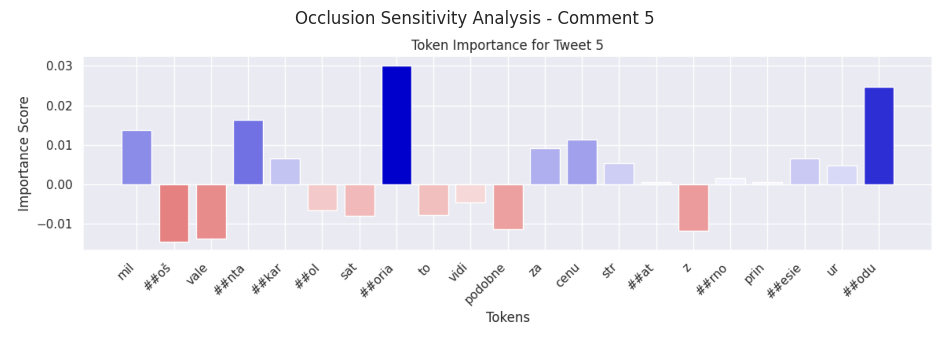

--------------------------------------------------------------------------------

=== Token Correlation Analysis ===

Generating explanations using token correlation analysis...

Processing tweet 1/5
Token correlation analysis for Tweet 1:
Text: jan kaislera job zabili mu deti
Plot saved to: correlation_tweet_1.png
Top contributing tokens:
  - '##a': 0.9550 (supporting the prediction)
      Without this token: 0.0401 confidence
  - '##i': 0.9368 (supporting the prediction)
      Without this token: 0.0583 confidence
  - '##sler': 0.9097 (supporting the prediction)
      Without this token: 0.0855 confidence
  - 'za': 0.3009 (supporting the prediction)
      Without this token: 0.6943 confidence
  - 'kai': 0.0345 (supporting the prediction)
      Without this token: 0.9607 confidence

Processing tweet 2/5
Token correlation analysis for Tweet 2:
Text: tomáš vybíralmas pravdu babis je laciny a podbizivy
Plot saved to: correlation_tweet_2.png
Top contributing tokens:
  - '##áš': -0.3518 (o

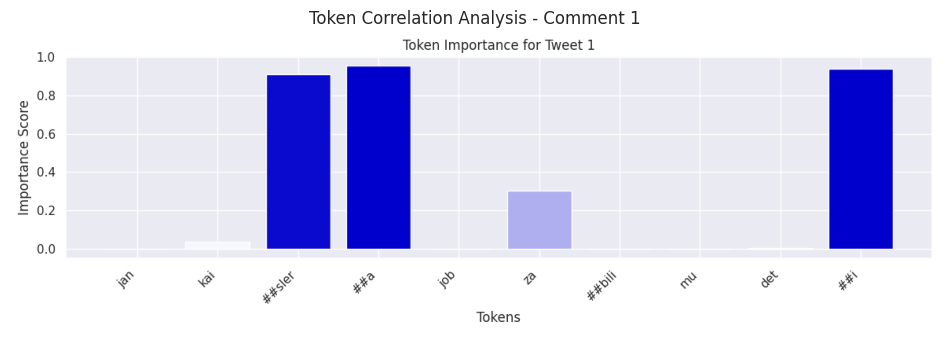

--------------------------------------------------------------------------------

Comment 2:
Text: tomáš vybíralmas pravdu babis je laciny a podbizivy

Most influential tokens (Correlation Analysis):
Token Importance     Effect
 ##áš    -0.3518   Opposing
  ##y    -0.2080   Opposing
  ##y    -0.2080   Opposing
    v     0.1626 Supporting
    a     0.1503 Supporting
  lac     0.1346 Supporting
##iny     0.1290 Supporting
 prav     0.1248 Supporting
   ba     0.1091 Supporting
 ##bi     0.1064 Supporting


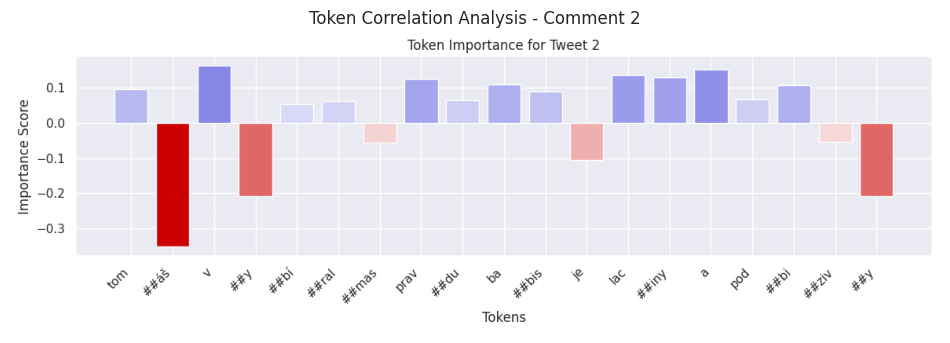

--------------------------------------------------------------------------------

Comment 3:
Text: jaroslav jiráčektak aspon ty nerad

Most influential tokens (Correlation Analysis):
Token Importance     Effect
  asp    -0.5354   Opposing
##ček    -0.4989   Opposing
   ji    -0.4661   Opposing
  ##d    -0.4288   Opposing
##ros     0.4066 Supporting
##lav     0.3874 Supporting
   ja     0.3850 Supporting
 ##on     0.3798 Supporting
##tak    -0.3259   Opposing
 ##rá    -0.2192   Opposing


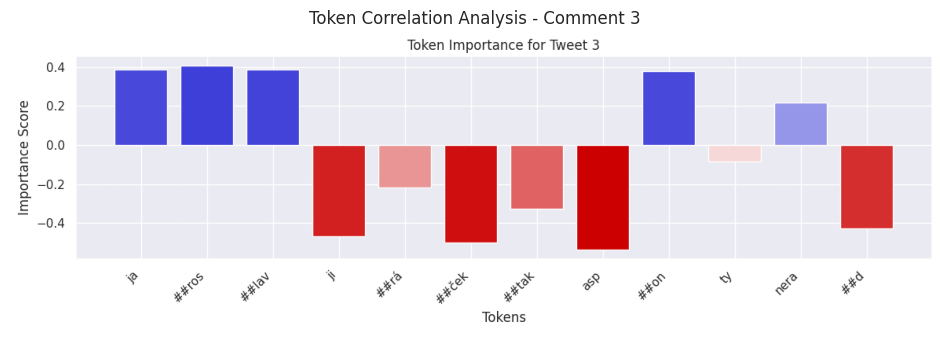

--------------------------------------------------------------------------------

Comment 4:
Text: slávek halaa nebo kdo je pravda pane pomtsky pilate

Most influential tokens (Correlation Analysis):
 Token Importance     Effect
   ##e     0.8462 Supporting
   ##k     0.7206 Supporting
    pi     0.4024 Supporting
    sl     0.3358 Supporting
   ##a     0.2482 Supporting
 ##sky     0.1838 Supporting
   pan     0.1798 Supporting
##late     0.1357 Supporting
  ##mt     0.0394 Supporting
    je    -0.0257   Opposing


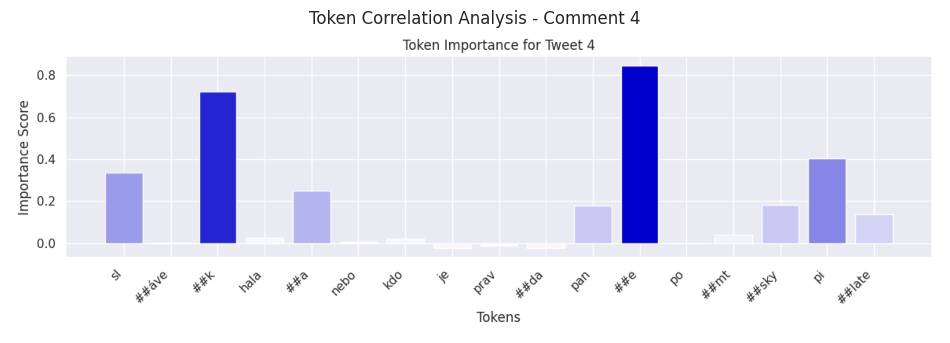

--------------------------------------------------------------------------------

Comment 5:
Text: miloš valentakarol satoria to vidi podobne za cenu strat zrno prinesie urodu

Most influential tokens (Correlation Analysis):
 Token Importance     Effect
   mil     0.6011 Supporting
##oria     0.0745 Supporting
  vale     0.0718 Supporting
  prin     0.0415 Supporting
  ##at     0.0397 Supporting
   sat     0.0393 Supporting
 ##odu     0.0187 Supporting
    ur     0.0169 Supporting
 ##nta     0.0134 Supporting
  ##ol    -0.0133   Opposing


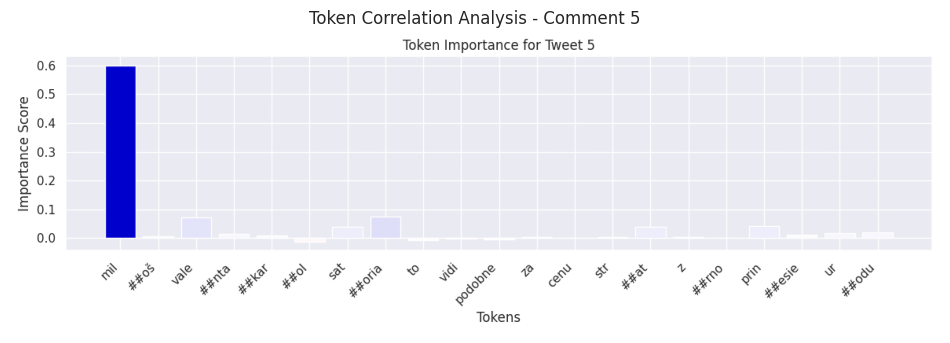

--------------------------------------------------------------------------------



Analyzing author: Milan Wolf
Prediction confidence: 0.901
Troll probability: 0.901

=== Occlusion Sensitivity Analysis ===

Generating explanations using occlusion sensitivity...

Processing tweet 1/5
Occlusion analysis for Tweet 1:
Text: bych to toho zmetka nenažranýho nechal zaplatit !
Plot saved to: importance_tweet_1.png
Top contributing tokens:
  - '!': 0.0113 (supporting the prediction)

Processing tweet 2/5
Occlusion analysis for Tweet 2:
Text: za taky ??? půlka jich tam chrápe druhá mele kraviny-je to práce snů…
Plot saved to: importance_tweet_2.png
Top contributing tokens:
  - '[UNK]': 0.4607 (supporting the prediction)
  - '##nů': -0.0256 (opposing the prediction)
  - 'za': -0.0223 (opposing the prediction)
  - 'p': -0.0162 (opposing the prediction)
  - 'krav': 0.0147 (supporting the prediction)
  - 'druhá': -0.0141 (opposing the prediction)
  - '##ka': 0.0139 (supporting the prediction)
  - '

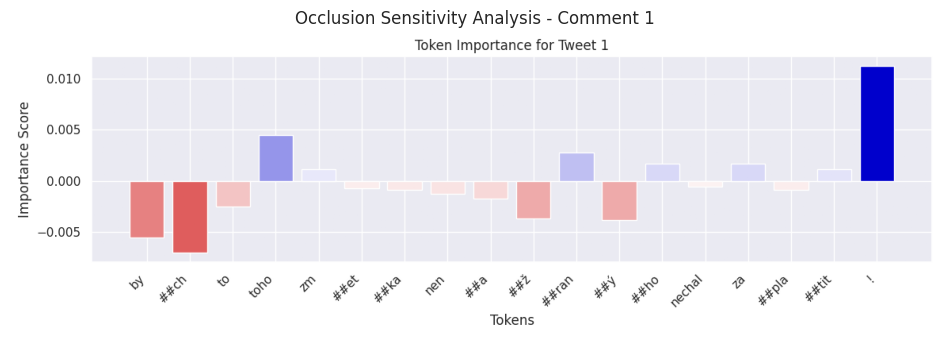

--------------------------------------------------------------------------------

Comment 2:
Text: za taky ??? půlka jich tam chrápe druhá mele kraviny-je to práce snů…

Most influential tokens (Occlusion Sensitivity):
Token Importance     Effect
[UNK]     0.4607 Supporting
 ##nů    -0.0256   Opposing
   za    -0.0223   Opposing
    p    -0.0162   Opposing
 krav     0.0147 Supporting
druhá    -0.0141   Opposing
 ##ka     0.0139 Supporting
 ##ůl    -0.0131   Opposing
práce    -0.0112   Opposing
 ##le     0.0111 Supporting


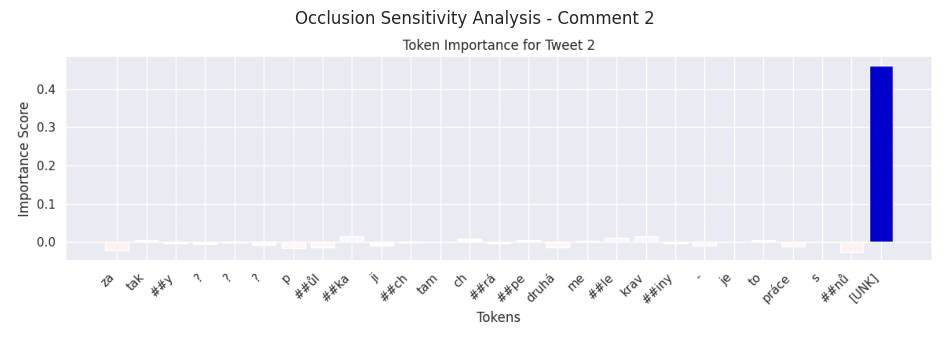

--------------------------------------------------------------------------------

Comment 3:
Text: filcko= největší slovenská ostuda !

Most influential tokens (Occlusion Sensitivity):
Empty DataFrame
Columns: [Token, Importance, Effect]
Index: []


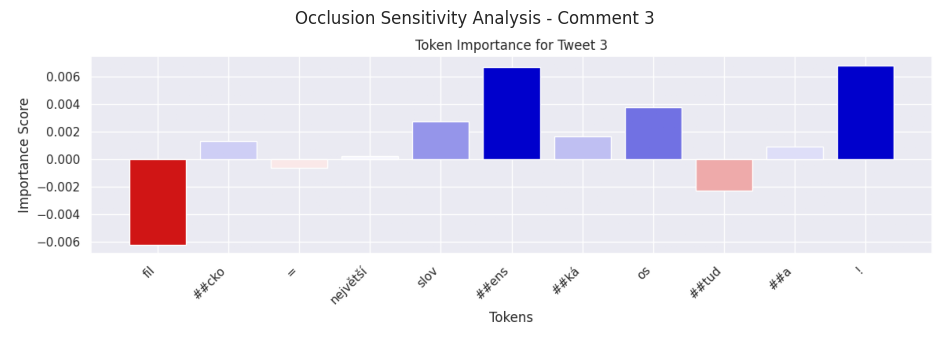

--------------------------------------------------------------------------------

Comment 4:
Text: tady může blábolit dementní retarda bláboliš který ani neví jak vzniká mléko-tohle ušatý jelito je ostudou národa !!!

Most influential tokens (Occlusion Sensitivity):
 Token Importance   Effect
   tad    -0.0240 Opposing
    je    -0.0179 Opposing
##lito    -0.0166 Opposing
  ##tý    -0.0149 Opposing
     u    -0.0147 Opposing
     -    -0.0146 Opposing
  ##ša    -0.0132 Opposing
  ##ék    -0.0131 Opposing
    to    -0.0130 Opposing
    je    -0.0129 Opposing


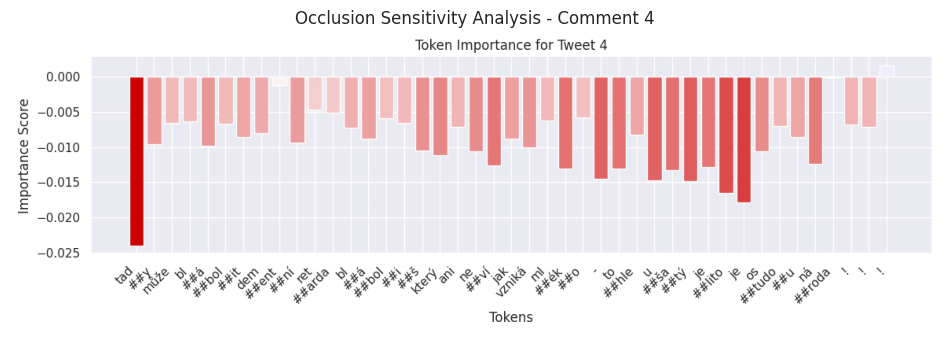

--------------------------------------------------------------------------------

Comment 5:
Text: nikdo normální ať už starej nebo mladej tuhle sektu prolhanejch zoufalců volit nebude …

Most influential tokens (Occlusion Sensitivity):
Token Importance     Effect
[UNK]     0.4231 Supporting


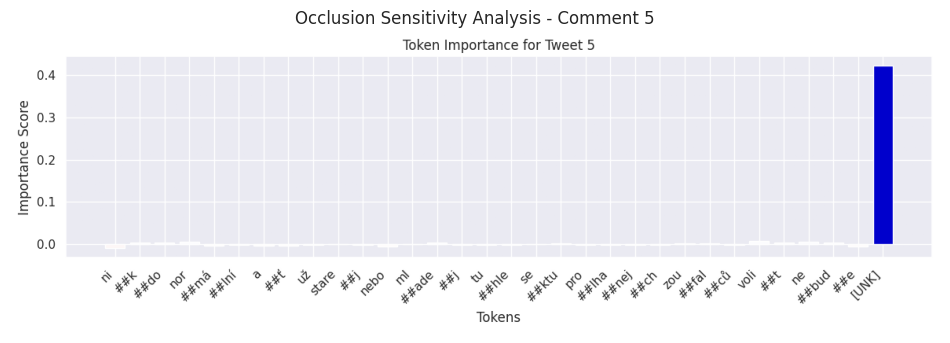

--------------------------------------------------------------------------------

=== Token Correlation Analysis ===

Generating explanations using token correlation analysis...

Processing tweet 1/5
Token correlation analysis for Tweet 1:
Text: bych to toho zmetka nenažranýho nechal zaplatit !
Plot saved to: correlation_tweet_1.png
Top contributing tokens:
  - '##ch': -0.1739 (opposing the prediction)
      Without this token: 0.1935 confidence
  - '##ž': -0.0221 (opposing the prediction)
      Without this token: 0.0417 confidence
  - 'zm': 0.0144 (supporting the prediction)
      Without this token: 0.0051 confidence
  - 'za': -0.0142 (opposing the prediction)
      Without this token: 0.0338 confidence
  - '##ho': 0.0139 (supporting the prediction)
      Without this token: 0.0057 confidence
  - '##tit': 0.0123 (supporting the prediction)
      Without this token: 0.0072 confidence
  - '##pla': 0.0112 (supporting the prediction)
      Without this token: 0.0083 confidence

Processi

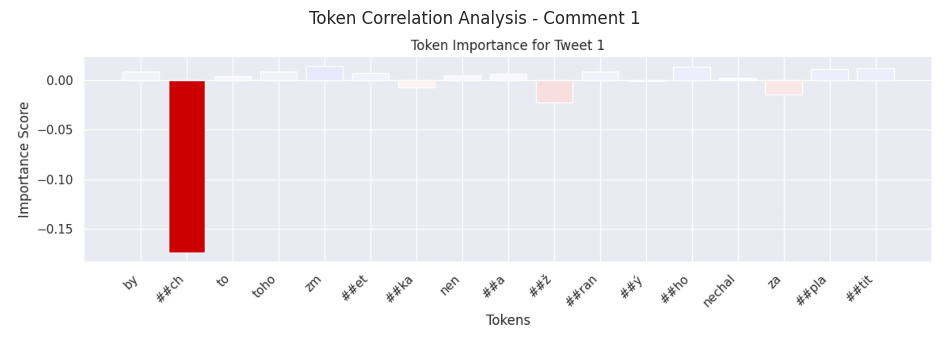

--------------------------------------------------------------------------------

Comment 2:
Text: za taky ??? půlka jich tam chrápe druhá mele kraviny-je to práce snů…

Most influential tokens (Correlation Analysis):
Token Importance     Effect
 ##nů     0.7020 Supporting
    s     0.0897 Supporting
  tak     0.0221 Supporting


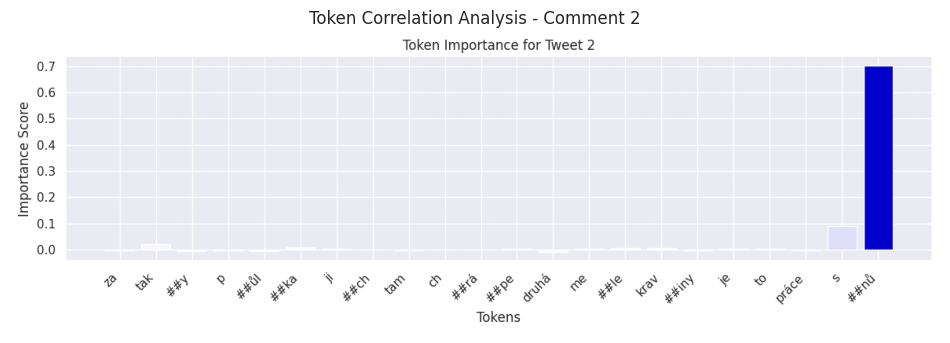

--------------------------------------------------------------------------------

Comment 3:
Text: filcko= největší slovenská ostuda !

Most influential tokens (Correlation Analysis):
   Token Importance     Effect
   ##ens     0.3604 Supporting
    slov     0.2836 Supporting
    ##ká     0.1283 Supporting
největší    -0.0959   Opposing
     fil    -0.0462   Opposing
   ##tud    -0.0433   Opposing
     ##a    -0.0244   Opposing
   ##cko    -0.0166   Opposing


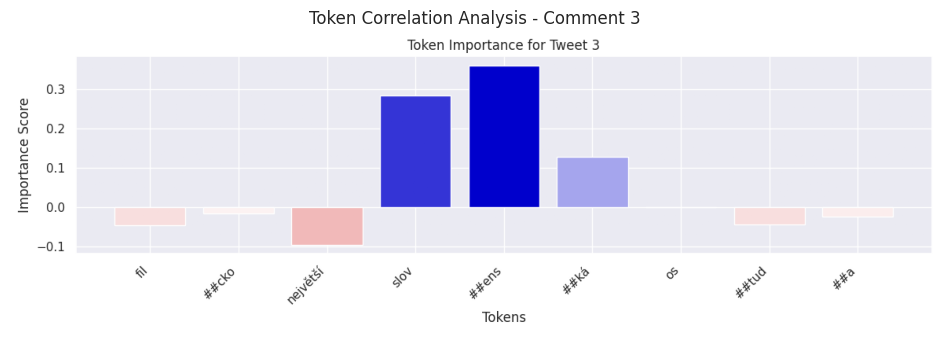

--------------------------------------------------------------------------------

Comment 4:
Text: tady může blábolit dementní retarda bláboliš který ani neví jak vzniká mléko-tohle ušatý jelito je ostudou národa !!!

Most influential tokens (Correlation Analysis):
Empty DataFrame
Columns: [Token, Importance, Effect]
Index: []


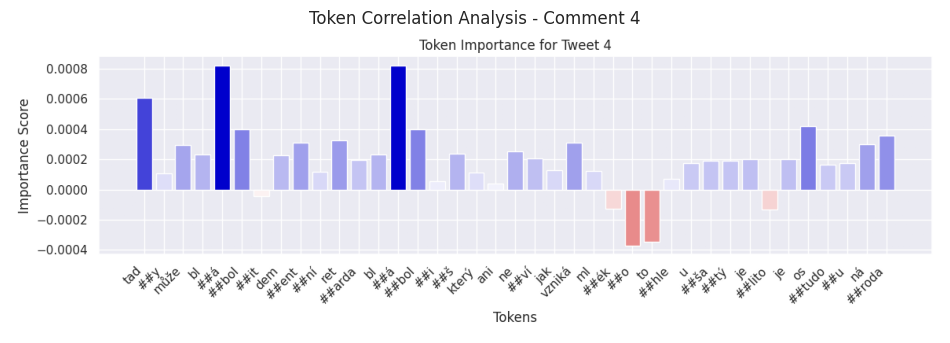

--------------------------------------------------------------------------------

Comment 5:
Text: nikdo normální ať už starej nebo mladej tuhle sektu prolhanejch zoufalců volit nebude …

Most influential tokens (Correlation Analysis):
Empty DataFrame
Columns: [Token, Importance, Effect]
Index: []


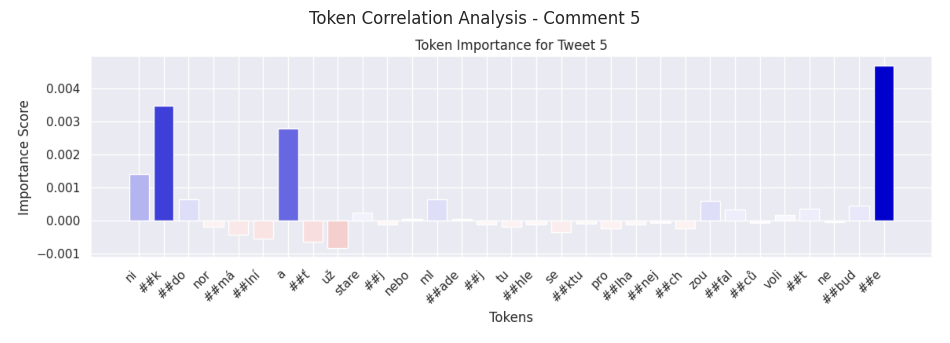

--------------------------------------------------------------------------------




In [51]:
# Example usage
# authors_to_explain = [
#     "Jitka Bártová",
#     "Roman Myška",   
# ]
authors_to_explain = [
    "Stefan Hinduliak",
    "Milan Wolf",   
]


for author in authors_to_explain:
    explain_author(
        author_name=author,
        predictor_instance=predictor,
        comments_df=czech_comments,
        display_plots=True,
        use_correlation=True
    )
    print("\n" + "="*80 + "\n")